In [1]:
import os
import pickle 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
import shap

In [ ]:
def plot_top_shap_per_class(class_name, class_names, shap_values, feature_names, top_n=10):
    """
    Plot the top N features for a given class using signed mean SHAP values.
    
    Parameters:
        class_name (str): Name of the class to plot.
        class_names (list or array): List of all class names (ordered as in shap_values).
        shap_values (ndarray): SHAP values of shape (n_samples, n_features, n_classes).
        feature_names (list): List of feature names (length = n_features).
        top_n (int): Number of top features to display.
    """
    try:
        i = list(class_names).index(class_name)
    except ValueError:
        raise ValueError(f"Class '{class_name}' not found in class_names.")

    class_shap = shap_values[:, :, i]
    mean_abs_shap = np.abs(class_shap).mean(axis=0)
    mean_signed_shap = class_shap.mean(axis=0)

    top_idx = np.argsort(mean_abs_shap)[-top_n:]
    top_features = np.array(feature_names)[top_idx]
    top_signed_values = mean_signed_shap[top_idx]

    colors = ['seagreen' if val > 0 else 'crimson' for val in top_signed_values]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_signed_values, color=colors)
    plt.title(f"Top {top_n} Features for Class: {class_name}\n(Signed Mean SHAP, Ranked by |SHAP|)")
    plt.xlabel("Mean SHAP Value")
    plt.axvline(0, color='gray', linestyle='--')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [119]:
def plot_top_shap_class(shap_values, class_name, class_names, feature_names, y_true, y_pred, mode="all preds", top_n=10):
    
    try:
        i = list(class_names).index(class_name)
    except ValueError:
        raise ValueError(f"Class '{class_name}' not found in class_names.")

    valid_modes = {"all preds", "entire class", "correct preds"}
    if mode not in valid_modes:
        raise ValueError(f"Invalid mode: '{mode}'. Choose from {valid_modes}.")

    if mode == "all preds":
        y_mask = np.ones(len(y_true), dtype=bool)
    elif mode == "entire class":
        y_mask = y_pred == i
    elif mode == "correct preds":
        y_mask = (y_true == i) & (y_pred == i)
    
    class_shap = shap_values[y_mask, :, i]
    mean_abs = np.abs(class_shap).mean(axis=0)
    mean_signed = class_shap.mean(axis=0)

    top_idx = np.argsort(mean_abs)[-top_n:]
    top_features = np.array(feature_names)[top_idx]
    top_signed_vals = mean_signed[top_idx]
    colors = ['seagreen' if v > 0 else 'crimson' for v in top_signed_vals]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_signed_vals, color=colors)
    plt.title(f"Top {top_n} Features for Class: {class_name}\n(SHAP values for relevant samples only)")
    plt.xlabel("Mean SHAP Value")
    plt.axvline(0, color='gray', linestyle='--')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [131]:
def plot_shap_feature(
    shap_values, 
    X, y_true, y_pred, 
    class_name, class_names, 
    feature_name, feature_names):
    
    try:
        i = list(class_names).index(class_name)
    except ValueError:
        raise ValueError(f"Class '{class_name}' not found in class_names.")
    
    # Get feature index
    try:
        f = list(feature_names).index(feature_name)
    except ValueError:
        raise ValueError(f"Feature '{feature_name}' not found in feature_names.")

    y_mask = y_pred == i
    feature_values = X.iloc[y_mask, f]
    shap_vals_for_class = shap_values[y_mask, f, i]
    correct = y_true[y_mask] == y_pred[y_mask]
    colors = ['seagreen' if c else 'crimson' for c in correct]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_values, shap_vals_for_class, c=colors, alpha=0.4, s=20, linewidths=0)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel(f"Feature Value: {feature_name}")
    plt.ylabel(f"SHAP Value for Class Index {i}")
    plt.title(f"SHAP vs {feature_name} (Class {i})")
    plt.tight_layout()
    plt.show()

In [129]:
def main():

    model_extras = os.path.join("..", "obj", "model_extras")
    models = os.path.join("..", "obj", "models")

    au_pairs = {
        "coffeeshop": "Coffee meetup",
        "royalty": "Royalty",
        "soulmates": "Soulmates",
        "vampire": "Vampires & werewolves",
    }

    fandom_pairs = {
        "bnha": "Heroes & villains",
        "bts": "Boyfriend bonding",
        "hp": "Magic",
        "mcu": "Soldier bonding"
    }

    for target in ["AU", "Fandom"]:

        model = joblib.load(os.path.join(models, f"xgb_{target}.pkl"))
        X_test = joblib.load(os.path.join(model_extras, f"X_test_{target}.pkl"))
        y_test = joblib.load(os.path.join(model_extras, f"y_test_{target}.pkl"))
        class_labels = joblib.load(os.path.join(model_extras, f"class_labels_{target}.pkl"))

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        preds = model.predict(X_test)
        feature_names = X_test.columns

        for c in class_labels:
                plot_top_shap_class(
                    shap_values, 
                    c, class_labels, 
                    feature_names, 
                    y_test, preds, 
                    mode="correct preds", 
                    top_n=10)

        if target == "AU":
            pairs = au_pairs
        elif target == "Fandom":
            pairs = fandom_pairs
        else:
            print("Double check target assignments...")

        for class_label, feature in pairs.items():
            plot_shap_feature(
                shap_values,
                X_test, y_test, preds,
                class_label, class_labels,
                feature, feature_names
            )
                

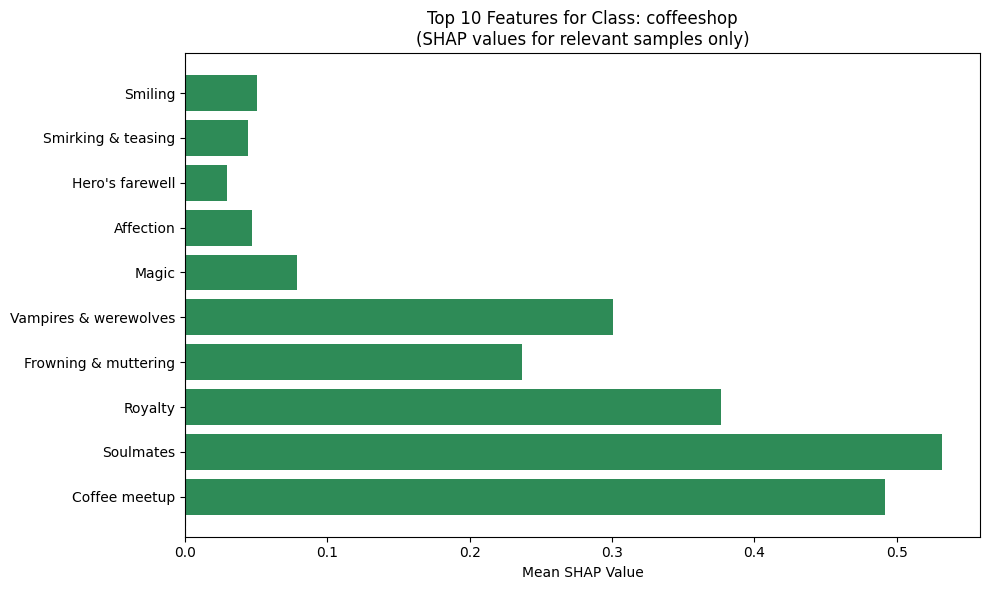

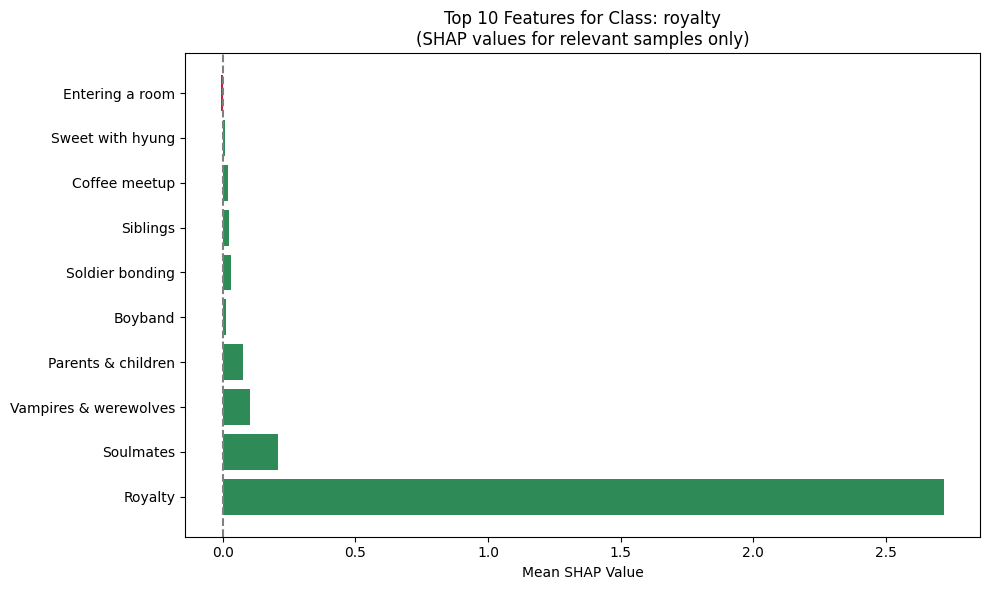

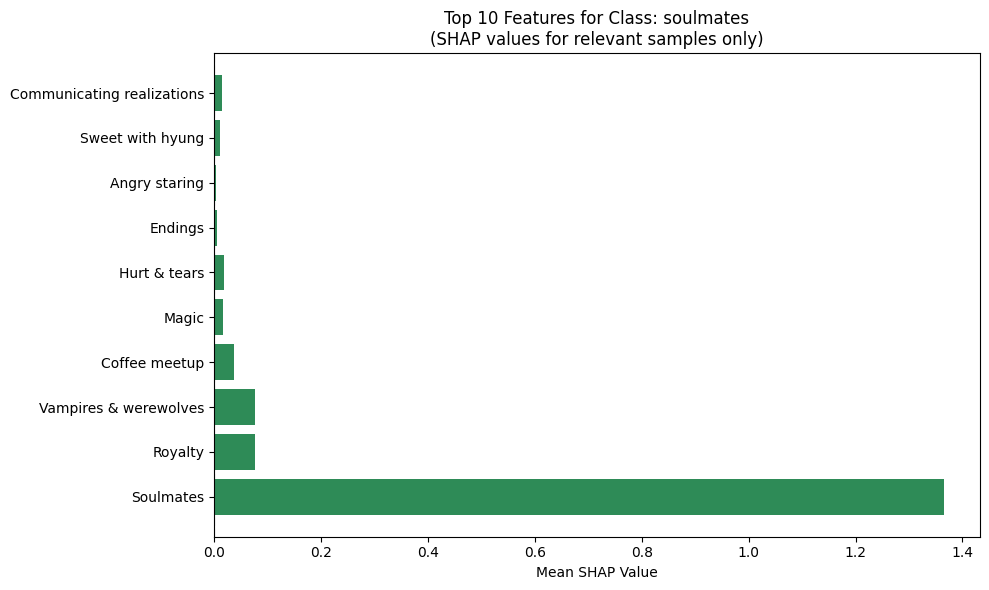

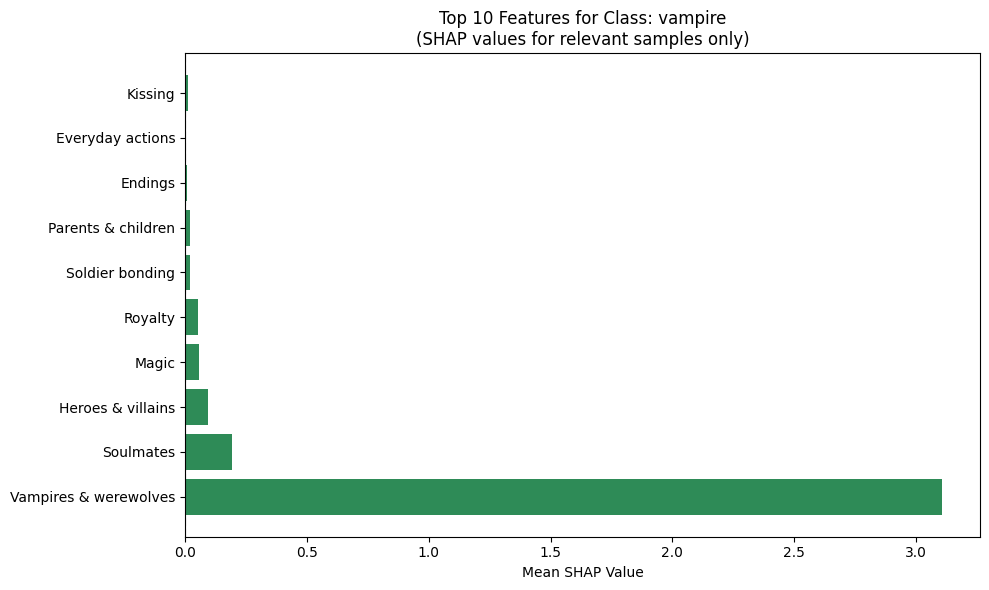

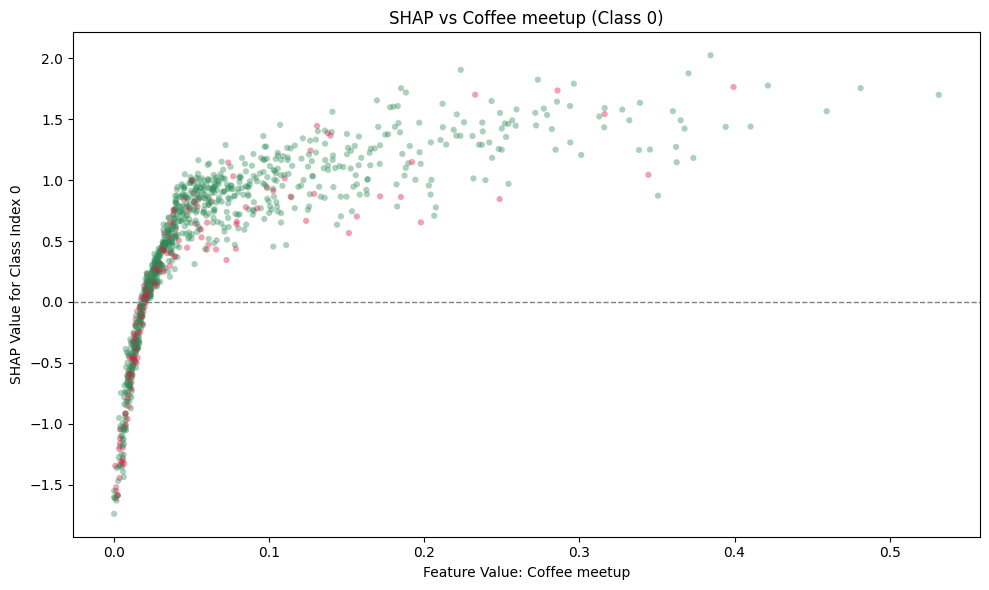

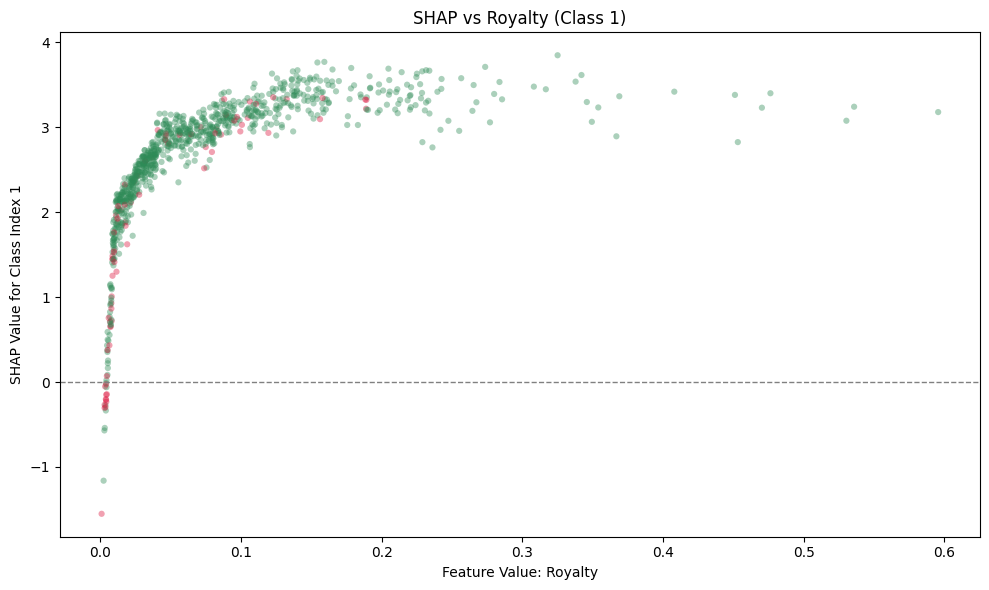

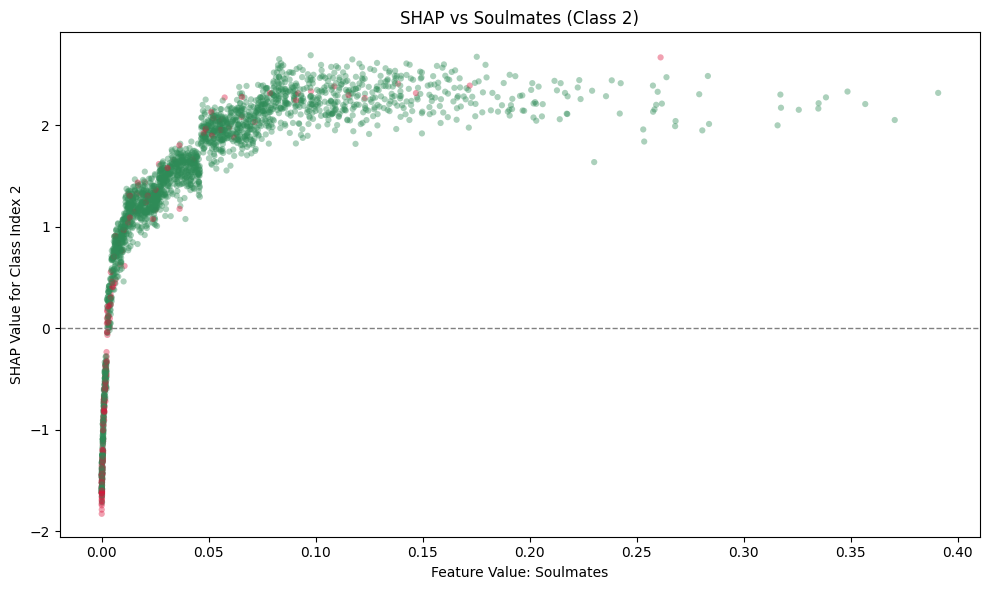

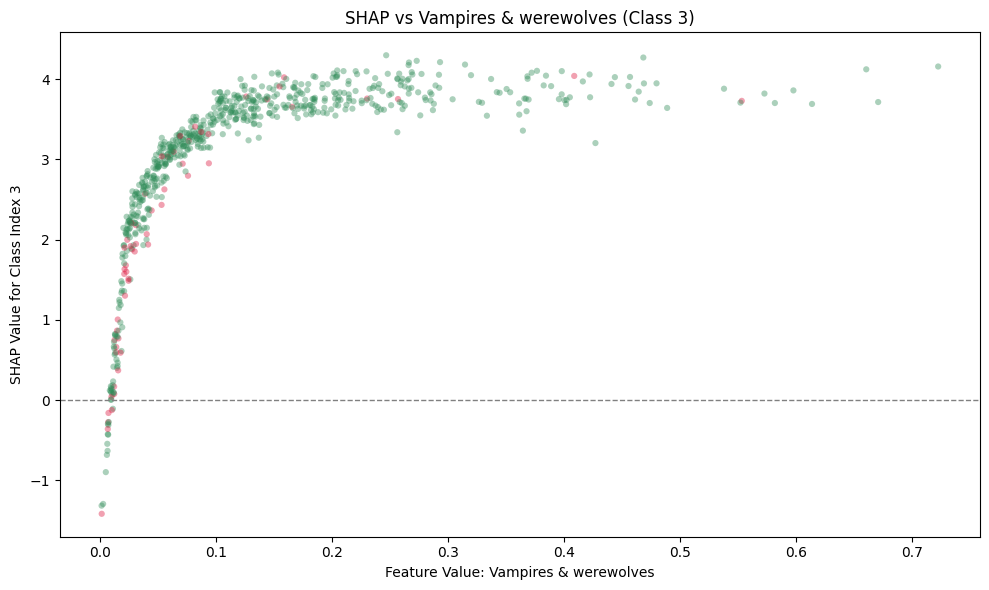

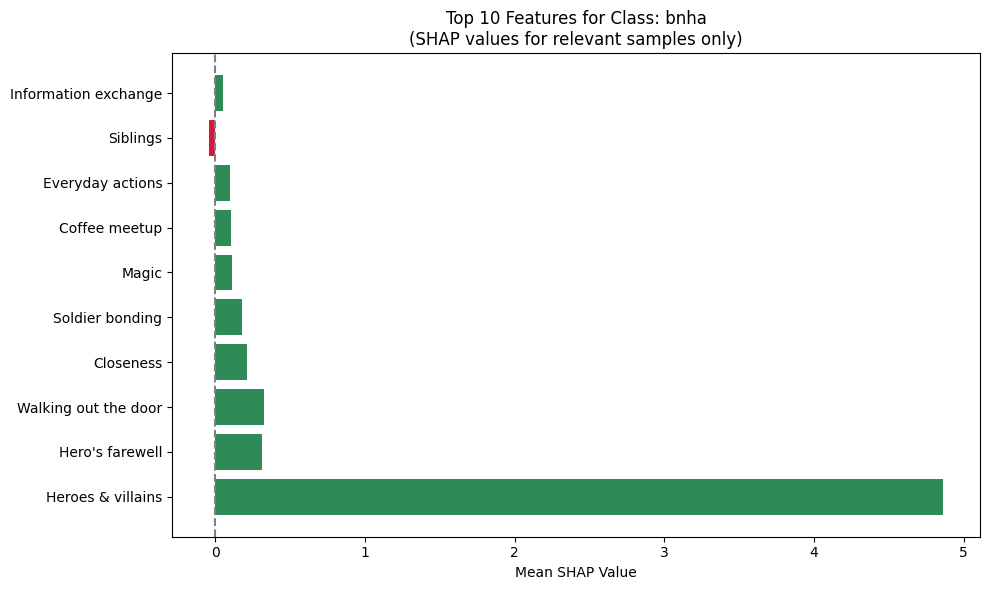

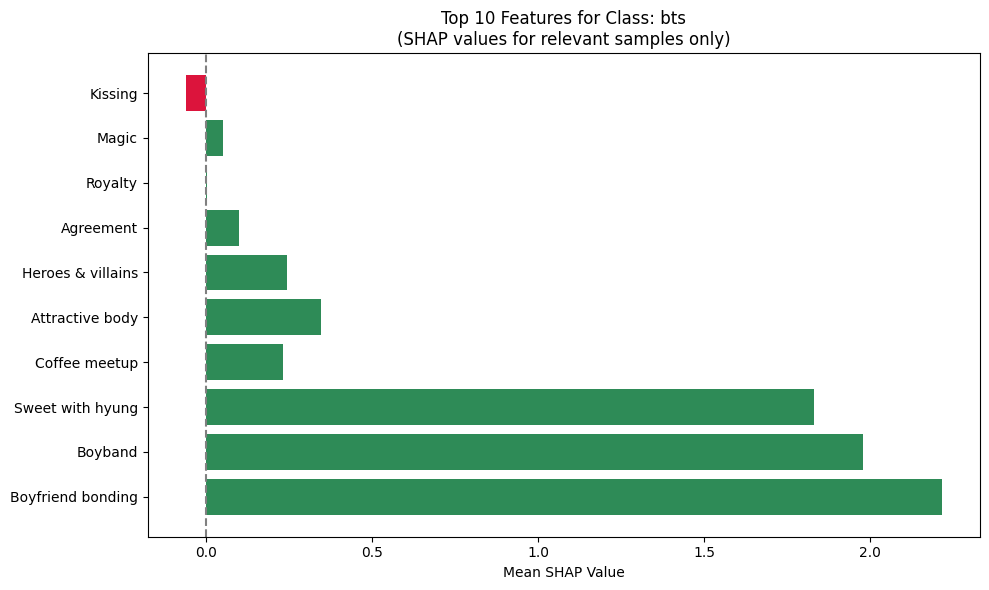

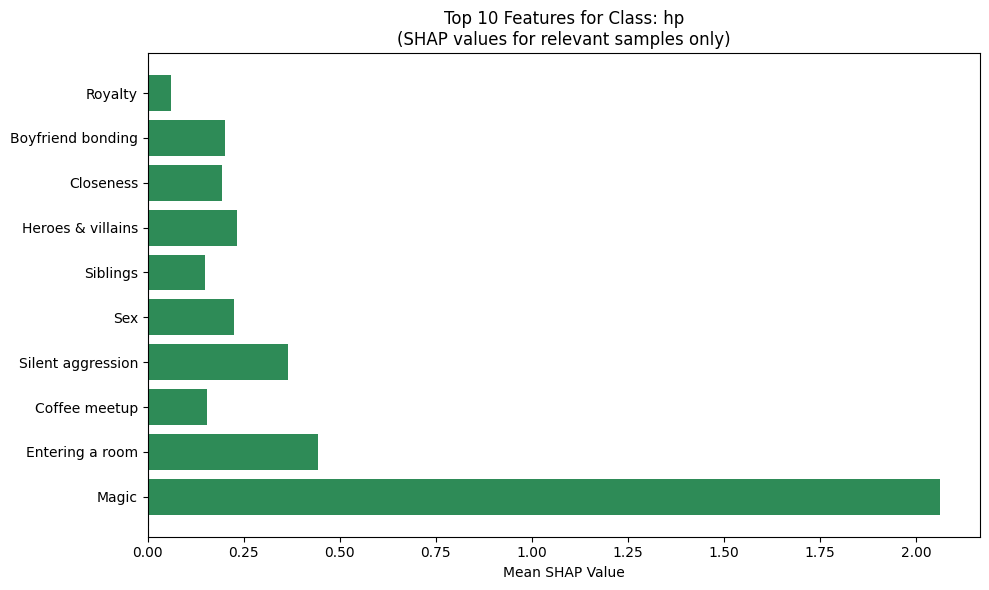

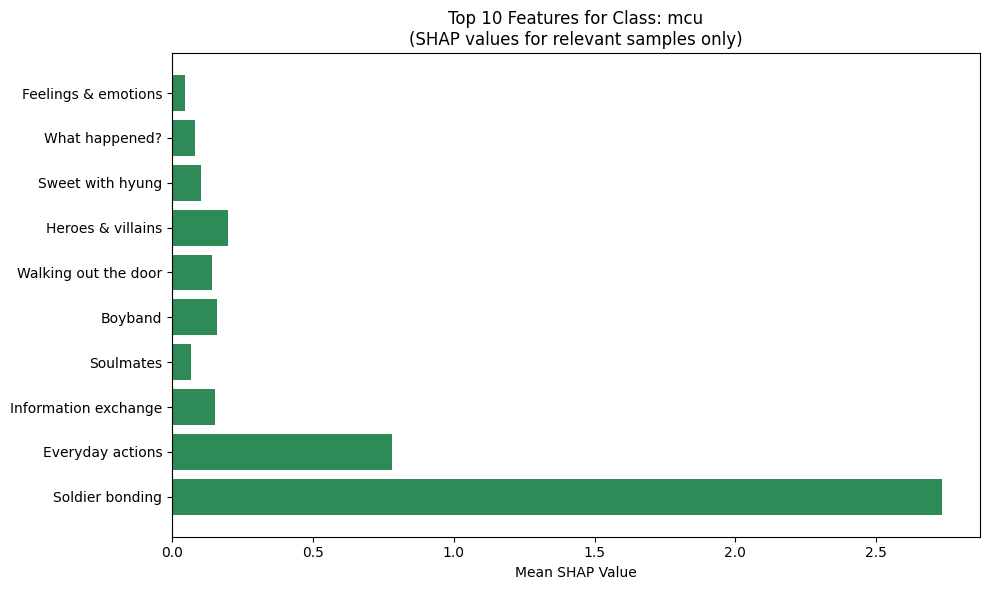

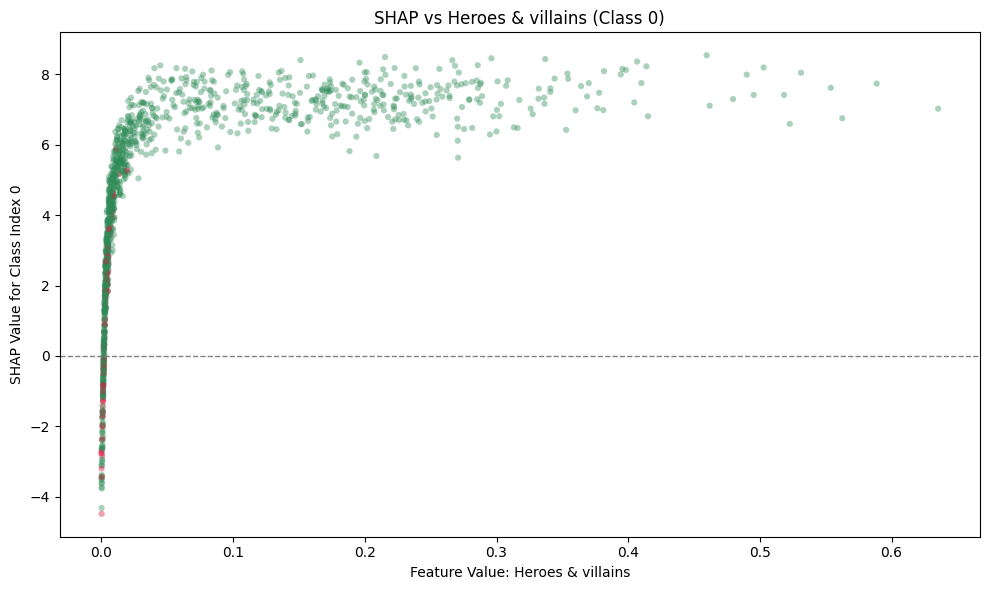

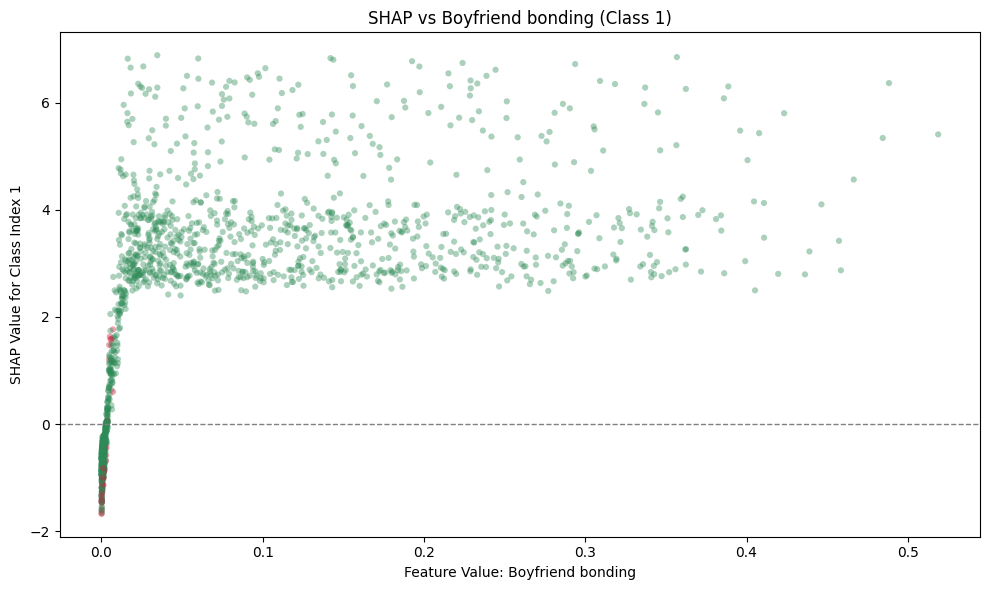

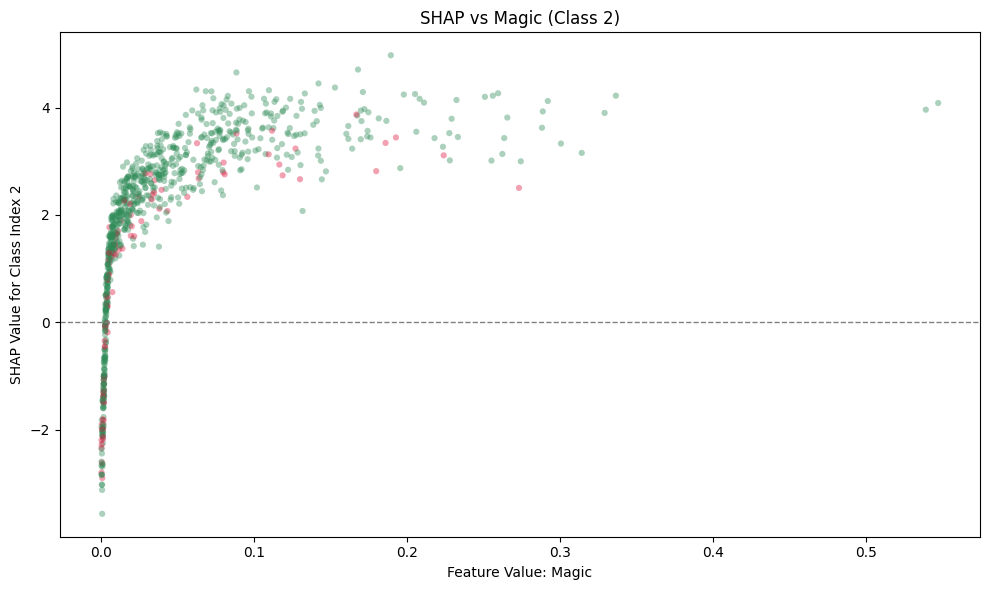

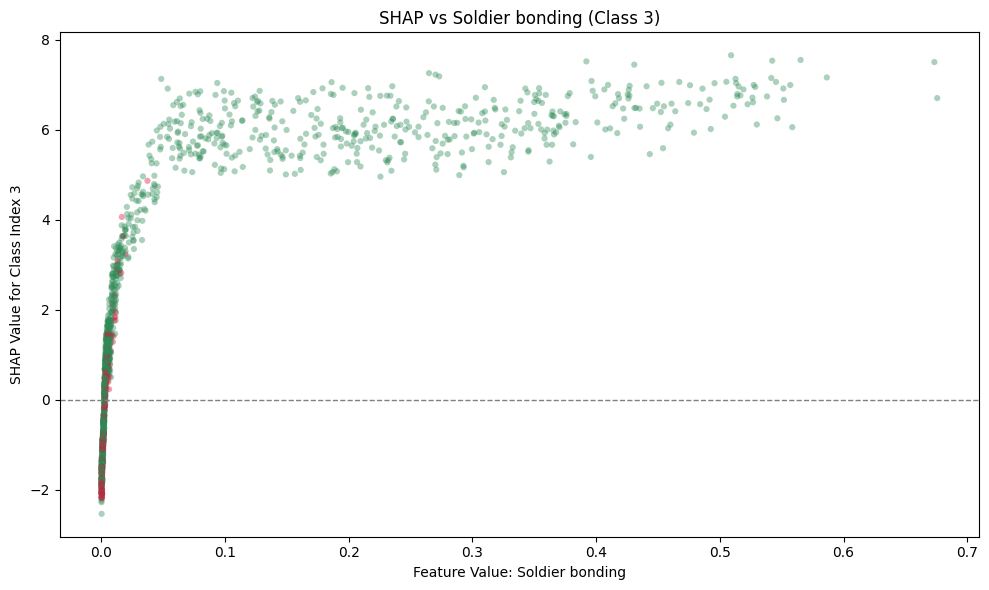

In [132]:
main()

In [94]:
df = joblib.load(os.path.join("..", "obj", "data", "NEe_final.pkl"))